In [20]:
%matplotlib inline

import os, sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import struct

import numpy as np
from matplotlib import pyplot as pl
import matplotlib as mpl
from time import time

import lal
import lalpulsar

# set the Earth and Sun ephemeris files, and the time units file
bpath = '/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/share/lalpulsar'
eephem = os.path.join(bpath, 'earth00-19-DE405.dat.gz')
sephem = os.path.join(bpath, 'sun00-19-DE405.dat.gz')
tephem = os.path.join(bpath, 'te405_2000-2019.dat.gz')

# import the ephemeris files
edat = lalpulsar.InitBarycenter(eephem, sephem)
tdat = lalpulsar.InitTimeCorrections(tephem)

# Reduced order modelling for barycentring time delays

For continuous gravitational wave searches, e.g. signals from pulsars, it is generally convinient for the signal's phase evolution to be in inertial frame such that it can be represented by a low order Taylor expansion
$$
\phi(t) = \phi_0 + 2\pi\left(f_0t + \frac{1}{2}\dot{f}_0t^2 + \frac{1}{6}\ddot{f}_0t^3 + \ldots \right).
$$
However, when such a signal arrives at a detector on the Earth it will contain additional modulations due to the Earth's relative motion to the source and relativitsic effects. The conversion between the equi-phase values measured in the topocentric frame to those measured in the inertial frame can be achieved through a transformation of the time coordinates
$$
t = t_{\text{inertial}} = t_{\text{topo}} + \tau(t_{\text{topo}}),
$$
where
$$
\tau(t_{\text{topo}}) \approx \Delta T_{\text{Roemer}}(t_{\text{topo}}) + \Delta T_{\text{Einstein}}(t_{\text{topo}}) - \Delta T_{\text{Shapiro}}(t_{\text{topo}}).
$$

The function $\tau(t_{\text{topo}})$ depends on where the detector is, and how it is moving, in relation to the source and the solar system barycentre. Therefore, its calculation requires the precise location of the detector on the Earth's geoid, ephemerides for the Earth-Moon system and Sun, and the sky coordinates of the source. 

If searching for signals spanning long durations (days-to-years) over a parameter space that covers sky location, then recalculating the required set of time delays over the length of the signal can become an expensive part of computating the expected signal evolution. The Earth-Moon and Sun ephemerides are precalculated look-up tables that can be read in from file once and interpolated between, however, the time delay function will still vary with sky position. I have been studying whether there is redundancy in the time delay over the sky, or in other words, whether there time delay calculated over extended lengths of time (e.g., a year long observing run) over a range of sky positions can be reduced down to a small set of basis functions. If possible this would allow the computation of the time delay function for new sky positions to be greatly sped-up.

In [37]:
# show the different time delays that make up tau

# get detector site info (we'll use LIGO H1 for this example)
det = lalpulsar.GetSiteInfo('H1')

# create BarycenterInput structure
baryinput = lalpulsar.BarycenterInput()

# setup input structure
baryinput.site = det
baryinput.site.location[0] = baryinput.site.location[0]/lal.C_SI # convert 3d position from metres to light seconds
baryinput.site.location[1] = baryinput.site.location[1]/lal.C_SI
baryinput.site.location[2] = baryinput.site.location[2]/lal.C_SI

baryinput.dInv = 0.0 # set the source to have very small (zero!) parallax

# set EarthState structure
earth = lalpulsar.EarthState()

# set EmissionTime structure
emit = lalpulsar.EmissionTime()

# set EarthState structure
earth = lalpulsar.EarthState()

# set EmissionTime structure
emit = lalpulsar.EmissionTime()

# set source sky position randomly from across the sky
#ra = 2.*np.pi*np.random.rand()
#dec = -(np.pi/2.) + np.arccos(2.*np.random.rand() - 1.)
ra = 0.  # fix RA (for reproducible results)
dec = 0. # fix dec

# set topocentric times over 1 year (once per 10 mins)
t = np.arange(900000000, 900000000+365.25*86400, 600)

deltaTs = np.zeros(len(t))   # total time delay (tau)
deltaRom = np.zeros(len(t))  # Roemer delay
deltaEin = np.zeros(len(t))  # Einstein delay
deltaSha = np.zeros(len(t))  # Shapiro delay (Earth geocentre to SSB)
deltaErot = np.zeros(len(t)) # Earth delay (detector to Earth geocentre)

# get deltaTs calculated using over all times using LALBarycenter routines
baryinput.delta = dec
baryinput.alpha = ra

# set GPS time
for j, tv in enumerate(t):
    tgps = lal.LIGOTimeGPS(int(np.floor(tv)), int(1e9*(tv-np.floor(tv))))

    # perform Earth barycentring
    lalpulsar.BarycenterEarthNew(earth, tgps, edat, tdat, lalpulsar.TIMECORRECTION_TCB)

    # perform barycentring
    lalpulsar.Barycenter(emit, baryinput, earth)

    deltaTs[j] = emit.deltaT
    deltaRom[j] = emit.roemer
    deltaSha[j] = emit.shapiro
    deltaErot[j] = emit.erot
    deltaEin[j] = earth.einstein

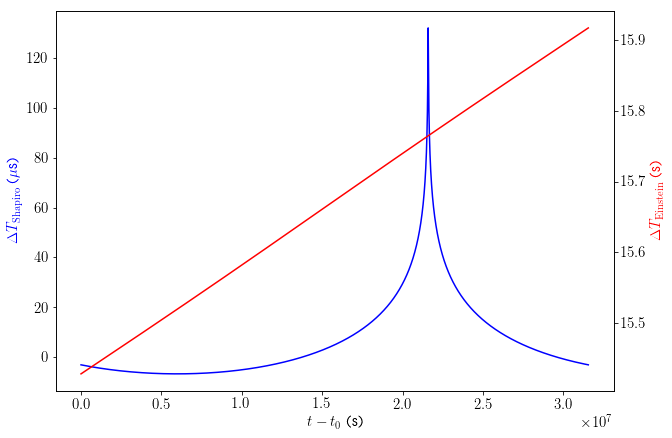

In [26]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] ='Avant Garde, Helvetica, Computer Modern Sans serif'
mpl.rcParams['font.size'] = 15

# plot the Shapiro delay and Einstein delays on separate axes
fig, ax1 = pl.subplots(figsize=(10,7))

ax1.plot(t-t[0], deltaSha*1e6, 'b')
ax1.set_xlabel(r'$t-t_0$ (s)')
ax1.set_ylabel(r'$\Delta T_{\rm{Shapiro}}$ ($\mu$s)', color='b')

ax2 = ax1.twinx()
ax2.plot(t-t[0], deltaEin, 'r')
ax2.set_ylabel(r'$\Delta T_{\rm{Einstein}}$ (s)', color='r')

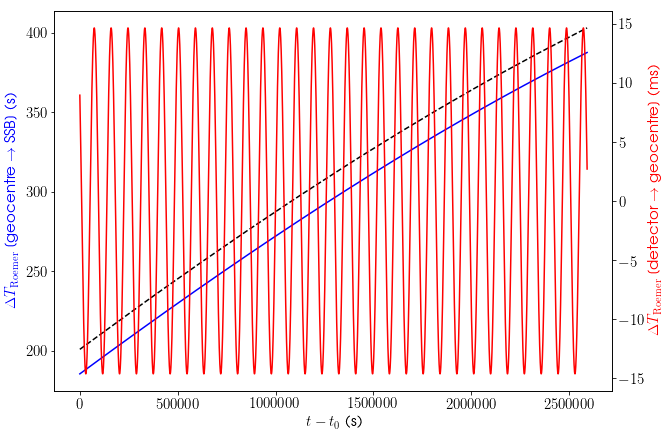

In [42]:
# plot geocentre to SSB and detector to geocentre Roemer delay terms (just do 1 month)
tm = np.arange(int(30.*86400/(600)), dtype=int)
fig, ax1 = pl.subplots(figsize=(10,7))

ax1.plot(t[tm]-t[0], deltaRom[tm], 'b')  # geocentre to SSB Roemer delay
ax1.plot(t[tm]-t[0], deltaTs[tm], 'k--') # overall delay from all terms
ax1.set_xlabel(r'$t-t_0$ (s)')
ax1.set_ylabel(r'$\Delta T_{\rm{Roemer}}$ [geocentre $\rightarrow$ SSB] (s)', color='b')

ax2 = ax1.twinx()
ax2.plot(t[tm]-t[0], deltaErot[tm]*1e3, 'r')
ax2.set_ylabel(r'$\Delta T_{\rm{Roemer}}$ [detector $\rightarrow$ geocentre] (ms)', color='r')

From the plots above we can see that the Shapiro delay term is cuspy and its location will depend heavily on the sky location, so it may be hard to incorporate into a reduced basis. However, the other terms do look ammenable to forming a reduced basis set.

To calculate a reduced basis I have made use of a version of the [`greedycpp`](https://bitbucket.org/sfield83/greedycpp) code [modified](https://github.com/mattpitkin/greedycpp/tree/redordbar) for this specific purpose. In `greedycpp` a reduced basis is found by implementation of the [Gram-Schmidt](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process) algorithm (see, e.g., Appendix A of [Canizares, _et al_, _PRD_, 87, 124005, 2013](http://adsabs.harvard.edu/abs/2013PhRvD..87l4005C)). New bases are added from a training set of bases until the maximum projection error of the current basis onto the rest of the training set is below some threshold. For these time delays we are not interested in projecting them onto other vectors, but instead are interested in the residual time delay (or potentially the phase mismatch caused by the residual time delay) that is left after using the reduced basis as an empirical interpolator [1][] to the training set. So, I have modified the code to calculate an empirical interpolator from the current reduced basis, and work out the maximum residual time delay of this against any of the remaining training bases. New bases cease to be added once the maximum time delay is less than $10^{-7}$ seconds.

[1]: This interpolator finds a set of points in the reduced basis set (equal to the number of reduced bases) at which interpolation from the reduced basis back to a full time vector can be performed, and the matrix from which the coefficients to interpolate with can be found.

In [128]:
# show test of residuals for one year (without Shapiro delay included)
rundir = '/home/matthew/repositories/greedycpp/scripts/barycenter/1year'

# get time stamps
ts = np.loadtxt(os.path.join(rundir, 'quad_rule.txt'))
t = ts[:,0]

lenb = len(t)

# get number of basis
Nb = np.loadtxt(os.path.join(rundir, 'ApproxErrors.txt')).shape[0]

# read in binary version of reduced basis data
bf = open(os.path.join(rundir,'Basis.bin'), 'rb')
fc = bf.read()
bf.close()

rb = np.zeros((Nb,lenb))
for i in range(Nb):
    tmpvals = struct.unpack('d'*lenb*2, fc[(i*8*lenb*2):(i+1)*8*lenb*2])
    rb[i] = tmpvals[::2] # just get real part
    
# read in binary version of empirical interpolation matrix
invV = np.zeros((Nb, Nb))
bf = open(os.path.join(rundir,'invV.bin'), 'rb')
fc = bf.read()
bf.close()
for i in range(Nb):
    tmpvals = struct.unpack('d'*Nb*2, fc[(i*8*Nb*2):(i+1)*8*Nb*2])
    invV[i] = tmpvals[::2] # just get real part
    
# get random sky positions and check residuals
nsky = 10
ras = 2.*np.pi*np.random.rand(nsky)
decs = -(np.pi/2.) + np.arccos(2.*np.random.rand(nsky) - 1.)

deltaTs = np.zeros(lenb)
deltaTsNoShap = np.zeros(lenb)
deltaEarthSE = np.zeros((lenb,3))
deltaEarthRSE = np.zeros(lenb)
deltaTsArray = []
deltaTsArrayNoShap = []
deltaEarthsSE = []
deltaEarthsRSE = []
# get deltaTs calculated using over all times using LALBarycenter routines
t0 = time()
for i in range(nsky):
    # set source sky position
    baryinput.alpha = ras[i]
    baryinput.delta = decs[i]

    # set GPS time
    for j, tv in enumerate(t):
        tgps = lal.LIGOTimeGPS(int(np.floor(tv)), int(1e9*(tv-np.floor(tv))))

        # perform Earth barycentring
        lalpulsar.BarycenterEarthNew(earth, tgps, edat, tdat, lalpulsar.TIMECORRECTION_TCB)

        # perform barycentring
        lalpulsar.Barycenter(emit, baryinput, earth)

        deltaTs[j] = emit.deltaT
        deltaTsNoShap[j] = emit.deltaT + emit.shapiro
        deltaEarthSE[j] = earth.se
        deltaEarthRSE[j] = earth.rse
    
    deltaTsArray.append(np.copy(deltaTs))
    deltaTsArrayNoShap.append(np.copy(deltaTsNoShap))
    deltaEarthsSE.append(np.copy(deltaEarthSE))
    deltaEarthsRSE.append(np.copy(deltaEarthRSE))
t1 = time()

timefull = t1-t0
print("time per evaluation = %.5f" % (timefull/float(nsky)))

time per evaluation = 2.82739


In [133]:
# get deltaTs calculated using interpolant
deltaTsArrayNew = []
deltaTsArrayNewNoShap = []
deltaTsCalcShap = []
dtvals = np.zeros(Nb)
dtvals2 = np.zeros(Nb)

ts_nodes = np.loadtxt(os.path.join(rundir, 'EIM_nodes.txt'))

B = np.dot(rb.T, invV).T

rsun = 2.322e0 #radius of sun in sec
shapiro = np.zeros(lenb)

# get deltats calculated using the reduced basis
t0 = time()
for i in range(nsky):
    # set source sky position
    baryinput.alpha = ras[i]
    baryinput.delta = decs[i]
    
    sa = np.sin(ras[i])
    ca = np.cos(ras[i])
    sd = np.sin(decs[i])
    cd = np.cos(decs[i])
    
    # get values of generate deltaT at given points
    for j, tv in enumerate(ts_nodes):
        tgps = lal.LIGOTimeGPS(int(np.floor(tv)), int(1e9*(tv-np.floor(tv))))

        # perform Earth barycentring
        lalpulsar.BarycenterEarthNew(earth, tgps, edat, tdat, lalpulsar.TIMECORRECTION_TCB)

        # perform barycentring
        lalpulsar.Barycenter(emit, baryinput, earth)

        dtvals[j] = emit.deltaT
        dtvals2[j] = emit.deltaT + emit.shapiro

    # create new version of deltaTs using empirical interpolant matrix
    deltaTsArrayNew.append(np.dot(dtvals, B))
    
    seDotN = deltaEarthsSE[i][:,2]*sd + (deltaEarthsSE[i][:,0]*ca + deltaEarthsSE[i][:,1]*sa)*cd
    b = np.sqrt(deltaEarthsRSE[i]**2 - seDotN*seDotN)
    idxs = (b < rsun) & (seDotN < 0.)
    shapiro[idxs] = 9.852e-6*np.log((lal.AU_SI/lal.C_SI)/(seDotN[idxs] + np.sqrt(rsun*rsun + seDotN[idxs]**2))) + 19.704e-6*(1. - b[idxs]/rsun)
    shapiro[~idxs] = 9.852e-6*np.log((lal.AU_SI/lal.C_SI)/(deltaEarthsRSE[i][~idxs] +seDotN[~idxs]))
    deltaTsArrayNewNoShap.append(np.dot(dtvals2, B))
    deltaTsCalcShap.append(np.dot(dtvals2, B) - shapiro)
t1 = time()

timereduced = t1-t0
print("time per evaluation = %.5f" % (timereduced/float(nsky)))

time per evaluation = 0.03687


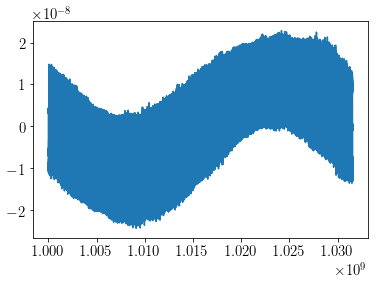

In [119]:
#pl.plot(t, np.dot(np.dot(invV, dtvals), rb))
#print np.dot(invV, dtvals)
pl.plot(t, deltaTsArrayNewNoShap[0]-deltaTsArrayNoShap[0])
#pl.plot(t, deltaTsArrayNewNoShap[0])

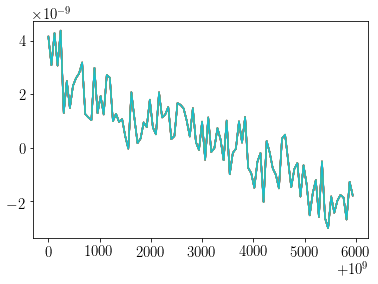

In [140]:
for dc, da in zip(deltaTsCalcShap, deltaTsArray):
    pl.plot(t[0:100], dc[0:100]-da[0:100])
#pl.plot(t, deltaTsArrayNew[0]-deltaTsArray[0])

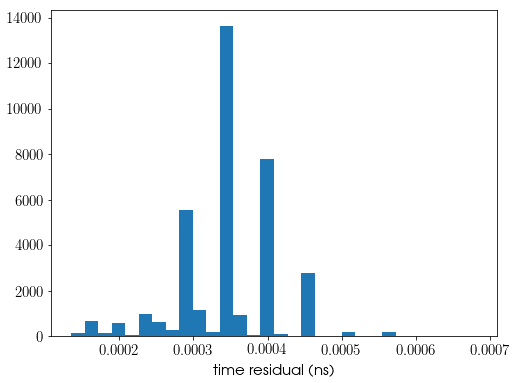

In [68]:
# show histograms of max time delay (when no including Shapiro delay) for all validation points
valpoints = np.loadtxt(os.path.join(rundir, 'all_validation_points.txt'))

fig, ax = pl.subplots(figsize=(8,6))

ax.hist(valpoints[:,4]*1e9, bins=30)
ax.set_xlabel('time residual (ns)')

In [46]:
B = np.array([[1., 2.], [-1., 4.]])
A = np.array([3., 2.3])
invB = np.linalg.inv(B)
C1 = np.dot(A, invB)

Bp = np.array([[1., 2., 4., 8., 9., 10], [-1., 4., 9., 3., 5., 11.]])

print np.dot(C1, Bp)
print np.dot(A, np.dot(invB, Bp))

[  3.           2.3          3.98333333  17.21666667  18.36666667  17.05      ]
[  3.           2.3          3.98333333  17.21666667  18.36666667  17.05      ]


1.01006467623e-08
7.72548404046e+29 7.56318199608e+29 9.78991342997e-09


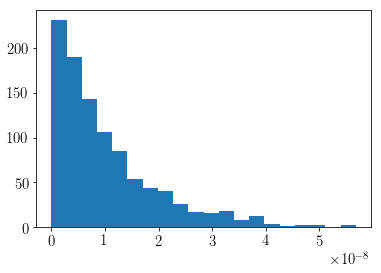

In [125]:
from scipy.stats import expon

ell = 1e-8
esamps = expon.rvs(scale=ell, size=1000)
pl.hist(esamps, bins=20)
print np.mean(esamps)

q22 = ell*1e38*np.sqrt(15./(8.*np.pi))
q22samps = expon.rvs(scale=q22, size=1000)
print q22, np.mean(q22samps), np.mean(q22samps)*np.sqrt(8.*np.pi/15)/1e38